In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
from scipy import sparse 
import itertools

import collections
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from umap import UMAP

from scroutines import basicu
from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *


In [2]:
def plot_pcs(res, npc, hue, palette=None):
    fig, axs = plt.subplots(npc-1,npc-1,figsize=(6*(npc-1),5*(npc-1)))
    for i, j in itertools.combinations(range(npc), 2):
        legend = False
        if (i,j) == (0,1): legend=True

        x, y = f"PC{j+1}", f"PC{i+1}"
        ax = axs[i,j-1]
        
        if palette is not None:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            hue_order=list(palette.keys()),
                            palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        else:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            # hue_order=list(palette.keys()),
                            # palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        sns.despine(ax=ax)
    axs[0,0].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

    for i, j in itertools.product(range(npc-1), range(npc-1)):
        if j<i:
            ax = axs[i,j]
            ax.axis('off')

    plt.show()

In [3]:
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results"
outfigdir  = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/"

In [4]:
adata_raw = anndata.read("../../data/cheng21_cell_scrna/reorganized/all_IT.h5ad")
adata_raw = adata_raw[adata_raw.obs['Subclass']=='L2/3']
adata_raw = adata_raw[adata_raw.obs['cond'].isin(['P28NR','P28DR'])]
counts = adata_raw.X
allgenes = adata_raw.var.index.values
adata_raw

View of AnnData object with n_obs × n_vars = 8748 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'

In [5]:
# get updated cell types
f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes.csv"
meta = pd.read_csv(f, index_col=0)
meta

/tmp/ipykernel_65358/12491127.py:3: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(f, index_col=0)


,Class_broad,Doublet,Doublet Score,batch,leiden,n_counts,n_genes,percent_mito,sample,Type,Subclass,cond,easitype,umap1,umap2,easisample,easicond,newtype
AAACGCTCACTTCATT-1-P8_1a-P8,Excitatory,False,0.025713,1,0,23384.0,4943,0.000128,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGATAGGTGCATG-1-P8_1a-P8,Excitatory,False,0.011883,1,0,17774.0,4698,0.000169,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGGCCAGTATACC-1-P8_1a-P8,Excitatory,False,0.024667,1,0,15872.0,4173,0.000126,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCCATATACCG-1-P8_1a-P8,Excitatory,False,0.027921,1,0,20076.0,4761,0.000050,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCTCAGATGCT-1-P8_1a-P8,Excitatory,False,0.009527,1,4,19061.0,4601,0.000000,P8_1a,L2/3_BC,L2/3,P8NR,L2/3_C,NaN,NaN,1a,1-P08NR,L2/3_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAGTTGTTG-1-P38_dr_1a,NaN,False,0.042872,11,1,11379.0,3568,0.000879,P38_dr_1a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,1a,2-P38DR,L2/3_B
TTTGGTTTCTGCCTGT-1-P38_dr_2b,NaN,False,0.007108,2,1,16050.0,3104,0.000062,P38_dr_2b,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2b,2-P38DR,L2/3_B
TTTGTTGCACCGGTCA-1-P38_dr_2a,NaN,False,0.030928,2,1,13955.0,3739,0.001146,P38_dr_2a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2a,2-P38DR,L2/3_B
TTTGTTGGTGGCTAGA-1-P38_dr_2b,NaN,False,0.015884,3,4,7272.0,2789,0.000963,P38_dr_2b,L2/3_2,L2/3,P38DR,L2/3_B,NaN,NaN,2b,2-P38DR,L2/3_A


In [6]:
# update new type 
adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()
adata_raw.obs.update(meta[['newtype']])

/tmp/ipykernel_65358/3478751590.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()


In [7]:
conds = adata_raw.obs['cond'].values
types = adata_raw.obs['Type'].values
newtypes = adata_raw.obs['newtype'].values
samps = adata_raw.obs['sample'].values

rename_dict = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}

def rename(x):
    """
    """
    if x in rename_dict.keys():
        return rename_dict[x]
    else:
        return x
    
adata_raw.obs['easitype'] = adata_raw.obs['Type'].apply(rename)

In [8]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values
# genes_sel = adata_raw.var.index.values
# genes_grp = df['P17on'].astype(str).values
# assert len(genes_sel) == len(np.unique(genes_sel))

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

In [9]:
# filter genes
cond = np.ravel((adata_raw.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata_sub = adata_raw[:,cond]

# counts
x = adata_sub.X
cov = adata_sub.obs['n_counts'].values
genes = adata_sub.var.index.values

# CP10k
xn = (sparse.diags(1/cov).dot(x))*1e4

# log10(CP10k+1)
xln = xn.copy()
xln.data = np.log10(xln.data+1)

adata_sub.layers['norm'] = xn
adata_sub.layers['lognorm'] = xln

In [10]:
# select HVGs with mean and var
nbin = 20
qth = 0.3

# mean
gm = np.ravel(xn.mean(axis=0))

# var
tmp = xn.copy()
tmp.data = np.power(tmp.data, 2)
gv = np.ravel(tmp.mean(axis=0))-gm**2

# cut 
lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))

# organize
gres = pd.DataFrame()
gres['name'] = genes
gres['lbl'] = lbl
gres['mean'] = gm
gres['var'] = gv
gres['ratio']= gv/gm

# select
gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)
assert np.all(gsel_idx != -1)

In [11]:
l23_gidx = basicu.get_index_from_array(genes, genes_l23)
assert np.all(l23_gidx != -1)

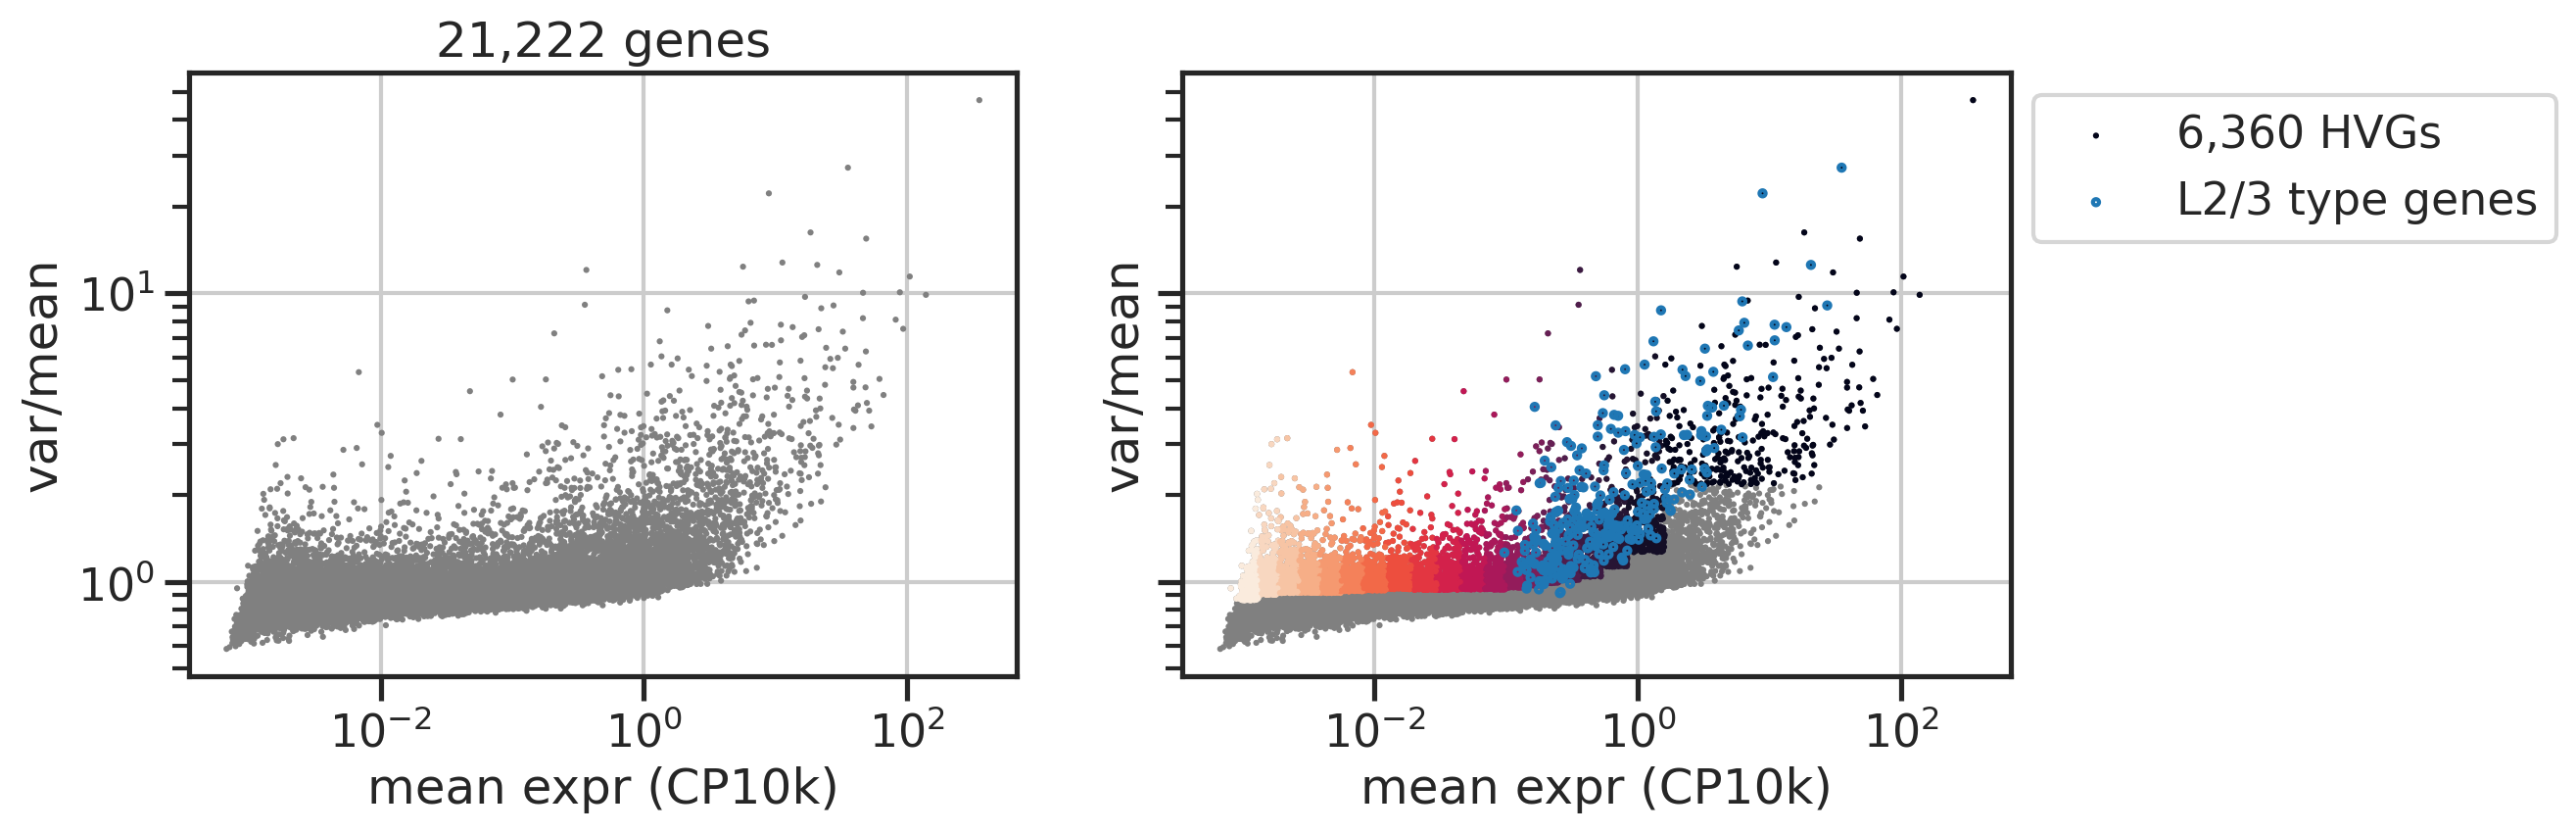

In [12]:
fig, axs = plt.subplots(1,2, figsize=(6*2,4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.set_title(f'{len(gm):,} genes')

ax = axs[1]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.scatter(gm[gsel_idx], (gv/gm)[gsel_idx], c=lbl[gsel_idx], s=5, edgecolor='none', cmap='rocket_r', label=f'{len(gsel_idx):,} HVGs')
ax.scatter(gm[l23_gidx], (gv/gm)[l23_gidx], s=5, facecolors='none', edgecolor='C0', label='L2/3 type genes')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.legend(bbox_to_anchor=(1,1))

plt.show()

In [13]:
adata = adata_sub[:,gsel_idx]
genes_sel = adata.var.index.values
adata

View of AnnData object with n_obs × n_vars = 8748 × 6360
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
    layers: 'norm', 'lognorm'

In [14]:
adata_nr = adata[adata.obs['cond']=='P28NR']
adata_nr1 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_1']
adata_nr1a = adata[adata.obs['sample']=='P28_1a']
adata_nr1b = adata[adata.obs['sample']=='P28_1b']
adata_nr2 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_2']

adata_dr = adata[adata.obs['cond']=='P28DR']
adata_dr1 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_dr_1']
adata_dr2 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_dr_3']

adata_nr, adata_dr, adata_nr1, adata_nr2, adata_dr1, adata_dr2

(View of AnnData object with n_obs × n_vars = 4044 × 6360
     obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
     layers: 'norm', 'lognorm',
 View of AnnData object with n_obs × n_vars = 4704 × 6360
     obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
     layers: 'norm', 'lognorm',
 View of AnnData object with n_obs × n_vars = 2071 × 6360
     obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
     layers: 'norm', 'lognorm',
 View of AnnData object with n_obs × n_vars = 1973 × 6360
     obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype',

In [15]:
def norm_pca(adata):
    
    np.random.seed(0)
    zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
    pca = PCA(n_components=50)
    
    zlognorm = np.nan_to_num(zlognorm, 0)
    pcs = pca.fit_transform(zlognorm)
    return pca

In [16]:


vt = norm_pca(adata).components_
vt_nr = norm_pca(adata_nr).components_
vt_dr = norm_pca(adata_dr).components_

vt_nr1 = norm_pca(adata_nr1).components_
vt_nr2 = norm_pca(adata_nr2).components_
vt_dr1 = norm_pca(adata_dr1).components_
vt_dr2 = norm_pca(adata_dr2).components_

vt_nr1a = norm_pca(adata_nr1a).components_
vt_nr1b = norm_pca(adata_nr1b).components_



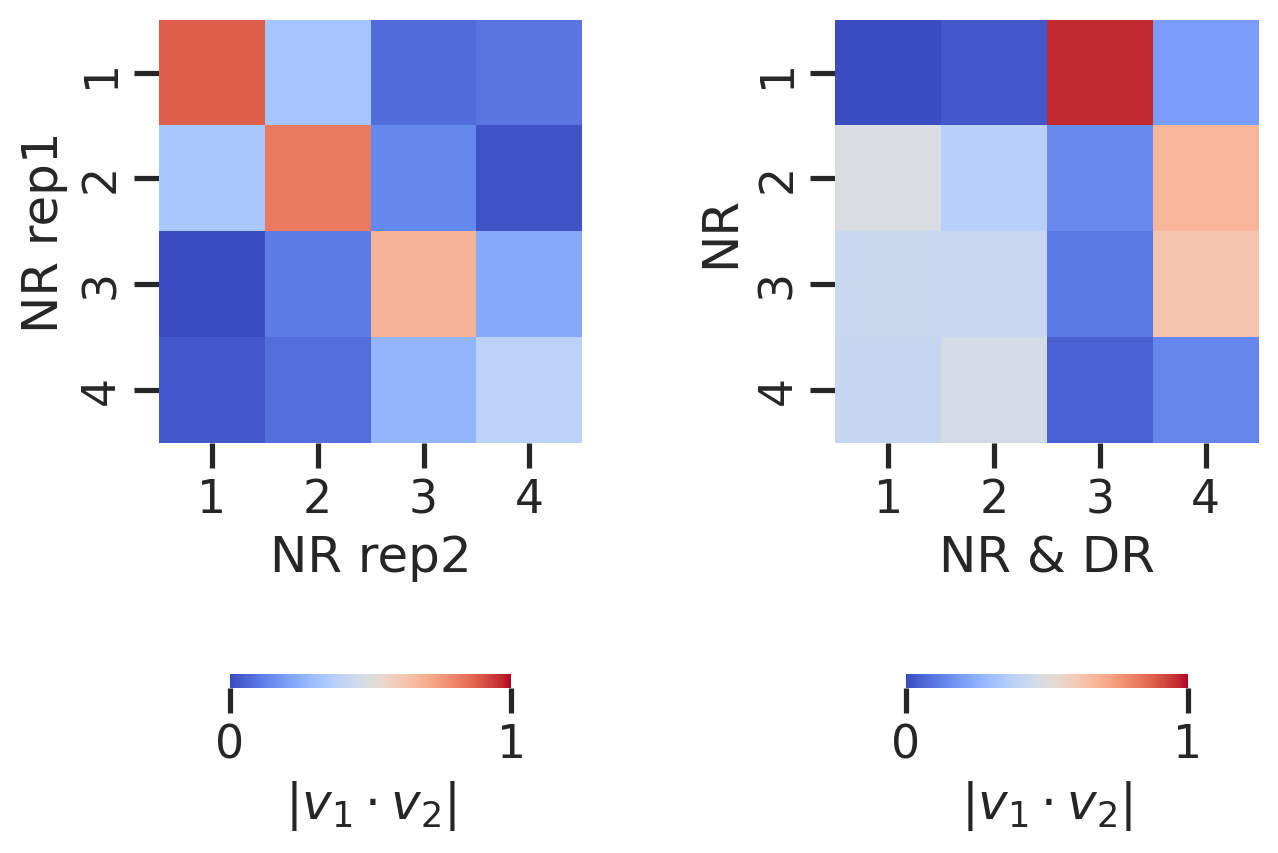

In [17]:

fig, axs = plt.subplots(1,2, figsize=(4*2,1*5))
n = 4
cases = [
    ["NR rep1", "NR rep2", np.abs(vt_nr1[:n].dot(vt_nr2[:n].T))],
    ["NR", "NR & DR", np.abs(vt_nr[:n].dot(vt[:n].T))],
]
for case, ax in zip(cases, axs):
    ylbl, xlbl, mat = case
    sns.heatmap(mat, 
                cmap='coolwarm', vmin=0, vmax=1,
                xticklabels=1, yticklabels=1, 
                cbar_kws=dict(location='bottom', shrink=0.5, label=r'$|v_1 \cdot v_2|$', pad=0.3, ticks=[0, 1]),
                ax=ax,
               )
    ax.set_xticklabels([int(i.get_text())+1 for i in ax.get_xticklabels()])
    ax.set_yticklabels([int(i.get_text())+1 for i in ax.get_yticklabels()])
    ax.set_aspect('equal')
    ax.set_ylabel(ylbl)
    ax.set_xlabel(xlbl)
output = os.path.join(outfigdir, 'pcdot_heatmap_main.pdf')
powerplots.savefig(fig, output)
plt.show()

In [18]:
pcbasis_dot = np.abs(vt_nr[:4].dot(vt[:4].T))
pcbasis_dot

array([[0.00331907, 0.02488093, 0.9645361 , 0.19266967],
       [0.48526436, 0.37344262, 0.14575621, 0.6745757 ],
       [0.43299055, 0.42410636, 0.10534412, 0.62744665],
       [0.4185382 , 0.46321166, 0.04713905, 0.13423797]], dtype=float32)

In [19]:
pcbasis_dot

array([[0.00331907, 0.02488093, 0.9645361 , 0.19266967],
       [0.48526436, 0.37344262, 0.14575621, 0.6745757 ],
       [0.43299055, 0.42410636, 0.10534412, 0.62744665],
       [0.4185382 , 0.46321166, 0.04713905, 0.13423797]], dtype=float32)

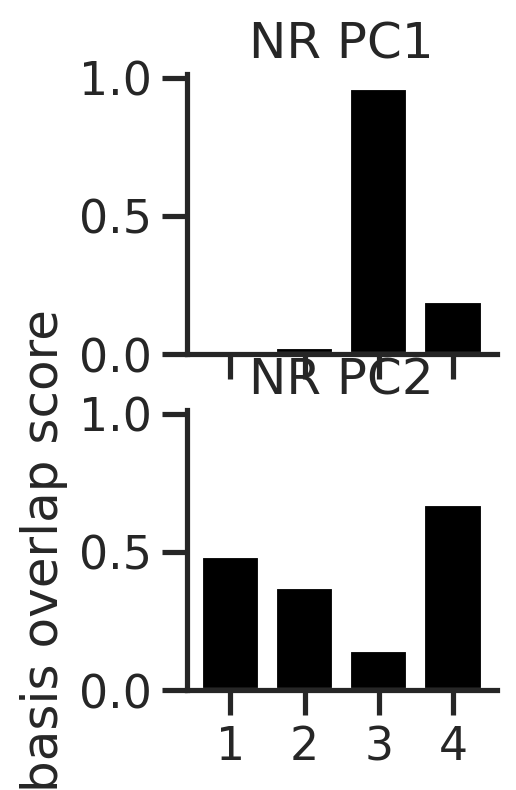

In [20]:
fig, axs = plt.subplots(2,1, figsize=(2,4), sharex=True, sharey=True)
ax = axs[0]
ax.bar(1+np.arange(4), pcbasis_dot[0], color='k')
ax.set_xticks(1+np.arange(4))
ax.grid(False)
sns.despine(ax=ax)
ax.set_title('NR PC1')

ax = axs[1]
ax.set_ylabel('basis overlap score')
ax.bar(1+np.arange(4), pcbasis_dot[1], color='k')
ax.grid(False)
sns.despine(ax=ax)
ax.set_xticks(1+np.arange(4))
ax.set_title('NR PC2')
plt.show()


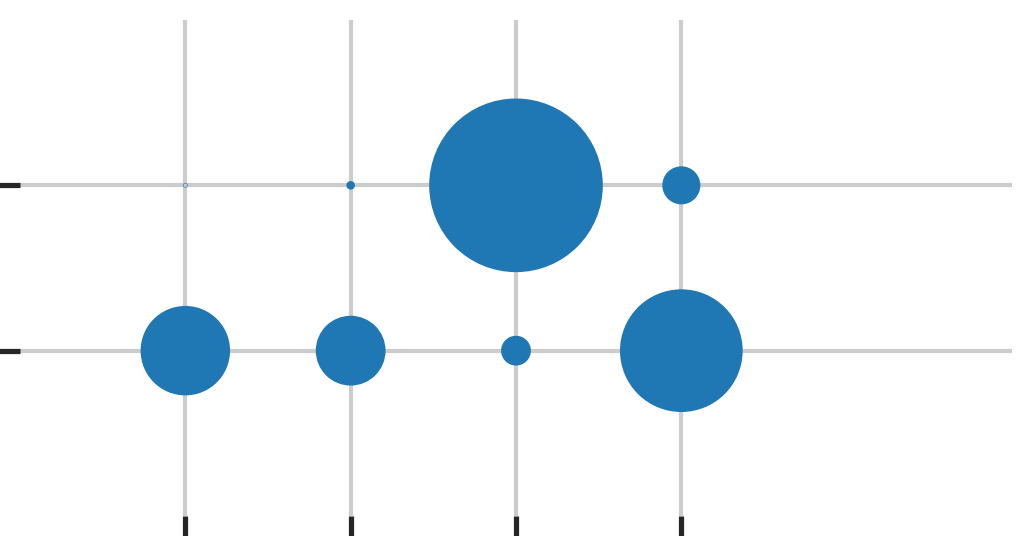

In [21]:
# bubble plot

x = 1+np.array([0,1,2,3]*2) 
y = 1+np.array(np.repeat([0,1],4)) 
s = pcbasis_dot[:2].reshape(-1,)

fig, ax = plt.subplots()
ax.scatter(x, y, s=(s**2)*4e3, clip_on=False)
ax.set_aspect('equal')
ax.set_xticks(np.unique(x))
ax.set_yticks(np.unique(y))
ax.invert_yaxis()
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.grid(False)
ax.set_xlim([ 0, 6])
ax.set_ylim([ 3, 0])
sns.despine(ax=ax, left=True, bottom=True)
output = os.path.join(outfigdir, 'bubble_plot.pdf')
plt.show()


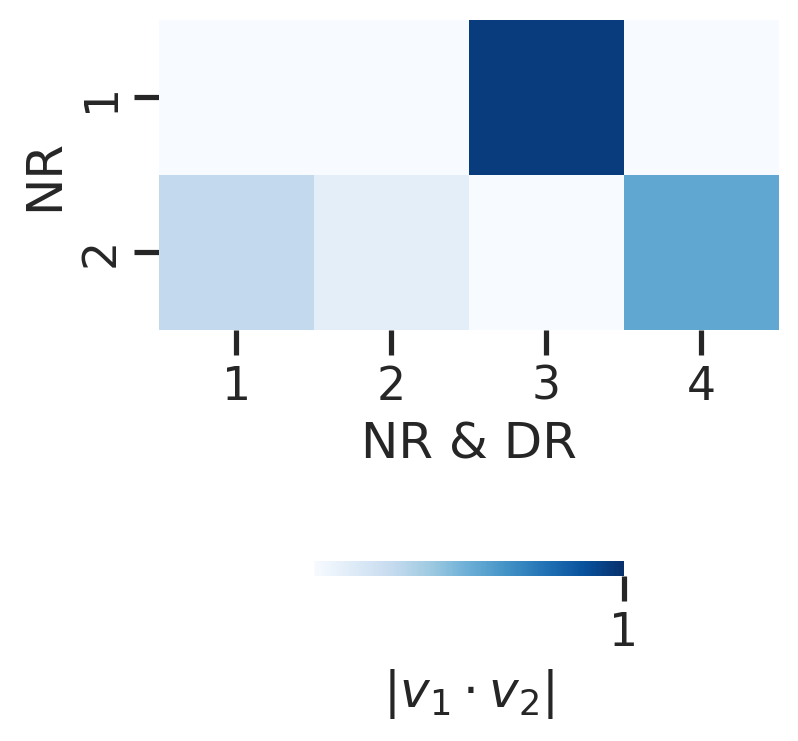

In [22]:
fig, ax = plt.subplots(1,1, figsize=(4*1,1*5))

ylbl, xlbl, mat = "NR", "NR & DR", np.abs(vt_nr[:2].dot(vt[:4].T))
sns.heatmap(mat, 
            cmap='Blues', vmin=0.3, vmax=1,
            xticklabels=1, yticklabels=1, 
            cbar_kws=dict(location='bottom', shrink=0.5, label=r'$|v_1 \cdot v_2|$', pad=0.3, ticks=[0, 1]),
            ax=ax,
           )
ax.set_xticklabels([int(i.get_text())+1 for i in ax.get_xticklabels()])
ax.set_yticklabels([int(i.get_text())+1 for i in ax.get_yticklabels()])
ax.set_aspect('equal')
ax.set_ylabel(ylbl)
ax.set_xlabel(xlbl)
output = os.path.join(outfigdir, 'pcdot_heatmap_main.pdf')
powerplots.savefig(fig, output)
plt.show()

In [23]:
import numpy as np
from scipy.linalg import svd

# Function to calculate principal angles
def principal_angles(A, B):
    # Orthonormalize the columns of A and B
    Q1, _ = np.linalg.qr(A)
    Q2, _ = np.linalg.qr(B)

    # Compute the SVD of the cross-product
    _, s, _ = svd(np.dot(Q1.T, Q2))

    # Principal angles are the arccos of the singular values
    angles = np.arccos(np.clip(s, -1.0, 1.0))
    return angles

_, s1, _ = svd(np.dot(vt_nr[:2], vt[:2].T))
_, s2, _ = svd(np.dot(vt_nr[:2], vt[2:4].T))
s1, s2

(array([0.61258316, 0.01768638], dtype=float32),
 array([0.9837077, 0.6899767], dtype=float32))

(6360,)

In [38]:
genes_sel[np.argsort(np.abs(vt[0]))[::-1]] # .shape

array(['Pcsk1n', 'Calm1', 'Nrgn', ..., 'Gm13405', 'AC116596.1',
       '1700027A15Rik'], dtype=object)

In [39]:
genes_sel[np.argsort(np.abs(vt[1]))[::-1]] # .shape

array(['Sik2', 'Homer1', 'Pcsk1', ..., 'Thrsp', 'A530065N20Rik',
       'Slc22a1'], dtype=object)

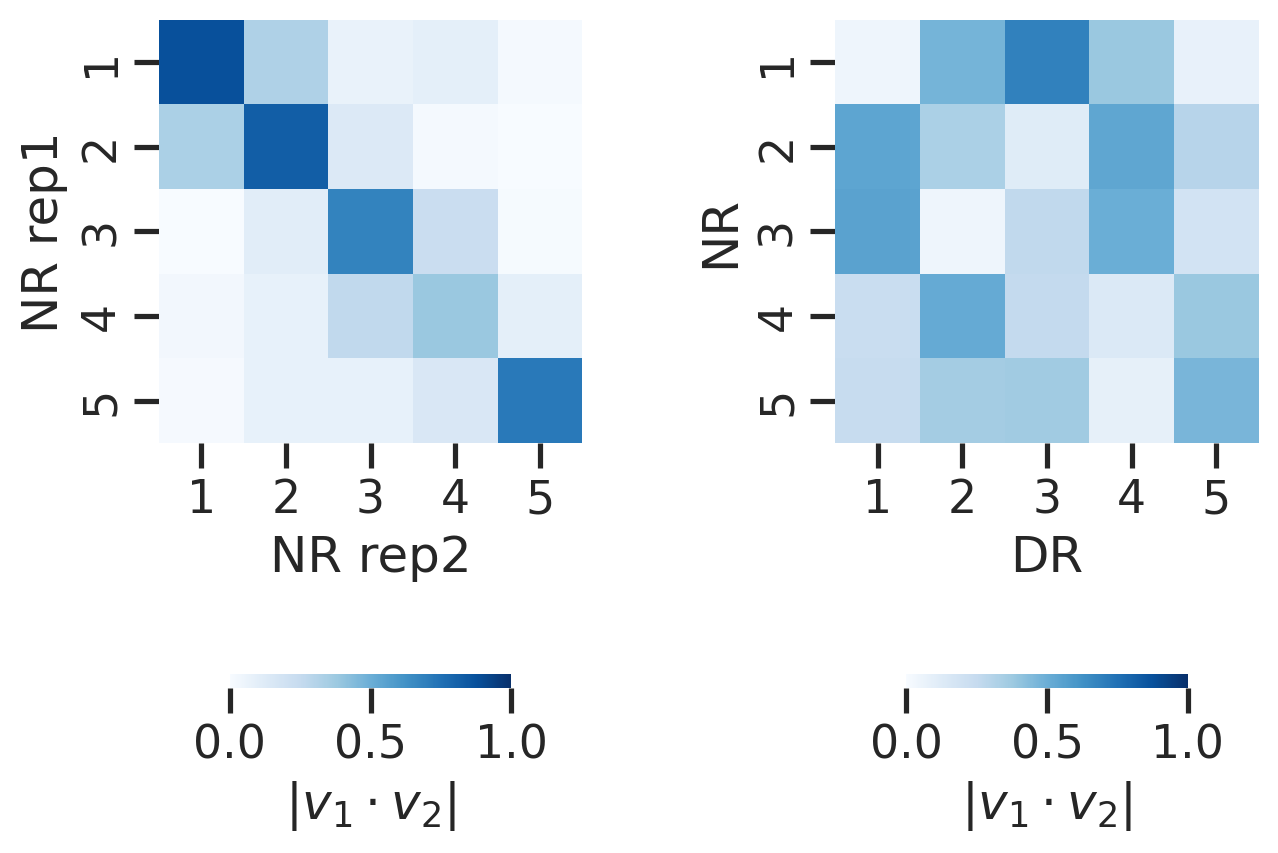

In [24]:

fig, axs = plt.subplots(1,2, figsize=(4*2,1*5))
cases = [
    ["NR rep1", "NR rep2", np.abs(vt_nr1[:5].dot(vt_nr2[:5].T))],
    ["NR", "DR", np.abs(vt_nr[:5].dot(vt_dr[:5].T))],
]
for case, ax in zip(cases, axs):
    ylbl, xlbl, mat = case
    sns.heatmap(mat, 
                cmap='Blues', vmin=0, vmax=1,
                xticklabels=1, yticklabels=1, 
                cbar_kws=dict(location='bottom', shrink=0.5, label=r'$|v_1 \cdot v_2|$', pad=0.3),
                ax=ax,
               )
    ax.set_xticklabels([int(i.get_text())+1 for i in ax.get_xticklabels()])
    ax.set_yticklabels([int(i.get_text())+1 for i in ax.get_yticklabels()])
    ax.set_aspect('equal')
    ax.set_ylabel(ylbl)
    ax.set_xlabel(xlbl)
output = os.path.join(outfigdir, 'pcdot_heatmap_main.pdf')
powerplots.savefig(fig, output)
plt.show()

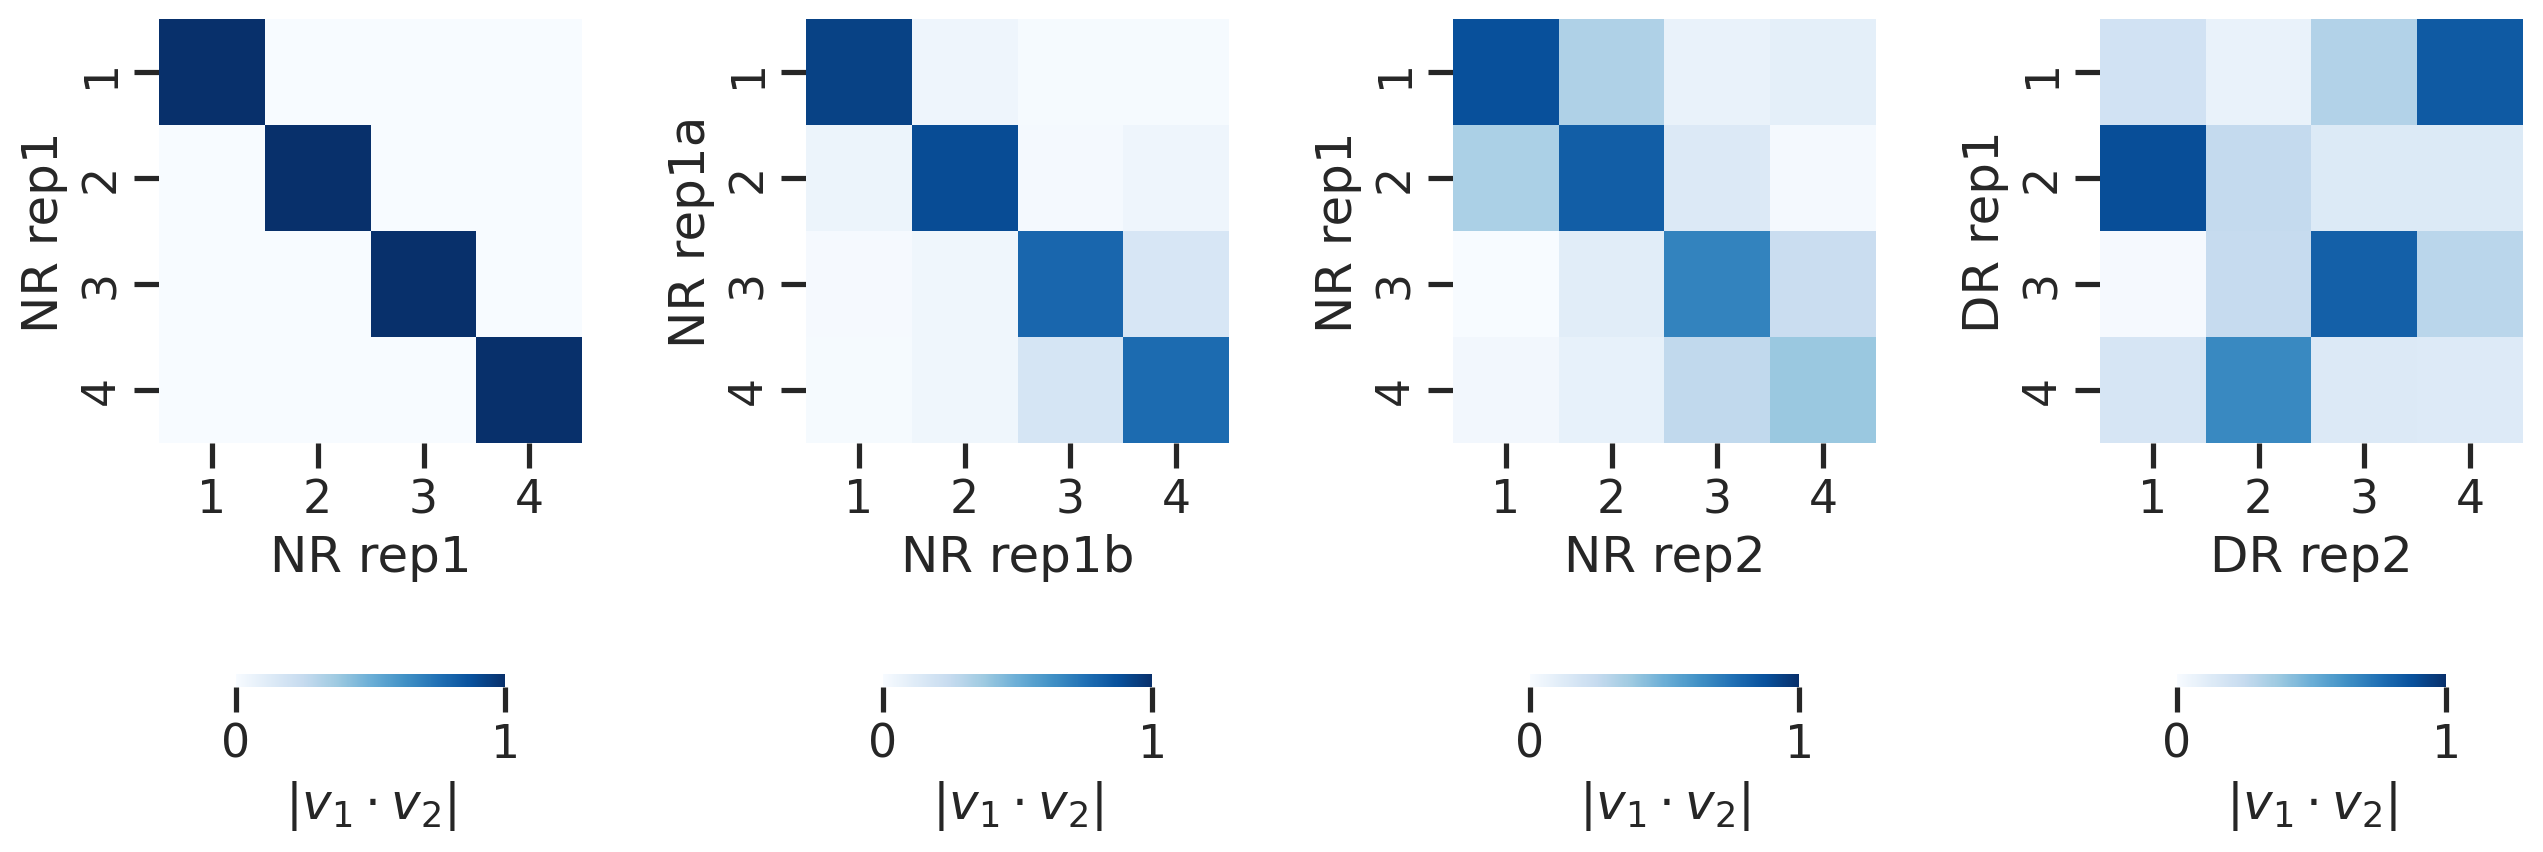

In [25]:
fig, axs = plt.subplots(1,4, figsize=(4*4,1*5))
n = 4
cases = [
    ["NR rep1", "NR rep1",   np.abs(vt_nr1[:n].dot(vt_nr1[:n].T))],
    ["NR rep1a", "NR rep1b", np.abs(vt_nr1a[:n].dot(vt_nr1b[:n].T))],
    ["NR rep1", "NR rep2",   np.abs(vt_nr1[:n].dot(vt_nr2[:n].T))],
    ["DR rep1", "DR rep2",   np.abs(vt_dr1[:n].dot(vt_dr2[:n].T))],
]
for case, ax in zip(cases, axs):
    ylbl, xlbl, mat = case
    sns.heatmap(mat, 
                cmap='Blues', vmin=0, vmax=1,
                xticklabels=1, yticklabels=1, 
                cbar_kws=dict(location='bottom', shrink=0.5, label=r'$|v_1 \cdot v_2|$', pad=0.3),
                ax=ax,
               )
    ax.set_xticklabels([int(i.get_text())+1 for i in ax.get_xticklabels()])
    ax.set_yticklabels([int(i.get_text())+1 for i in ax.get_yticklabels()])
    ax.set_aspect('equal')
    ax.set_ylabel(ylbl)
    ax.set_xlabel(xlbl)
output = os.path.join(outfigdir, 'pcdot_heatmap_s1.pdf')
powerplots.savefig(fig, output)
plt.show()

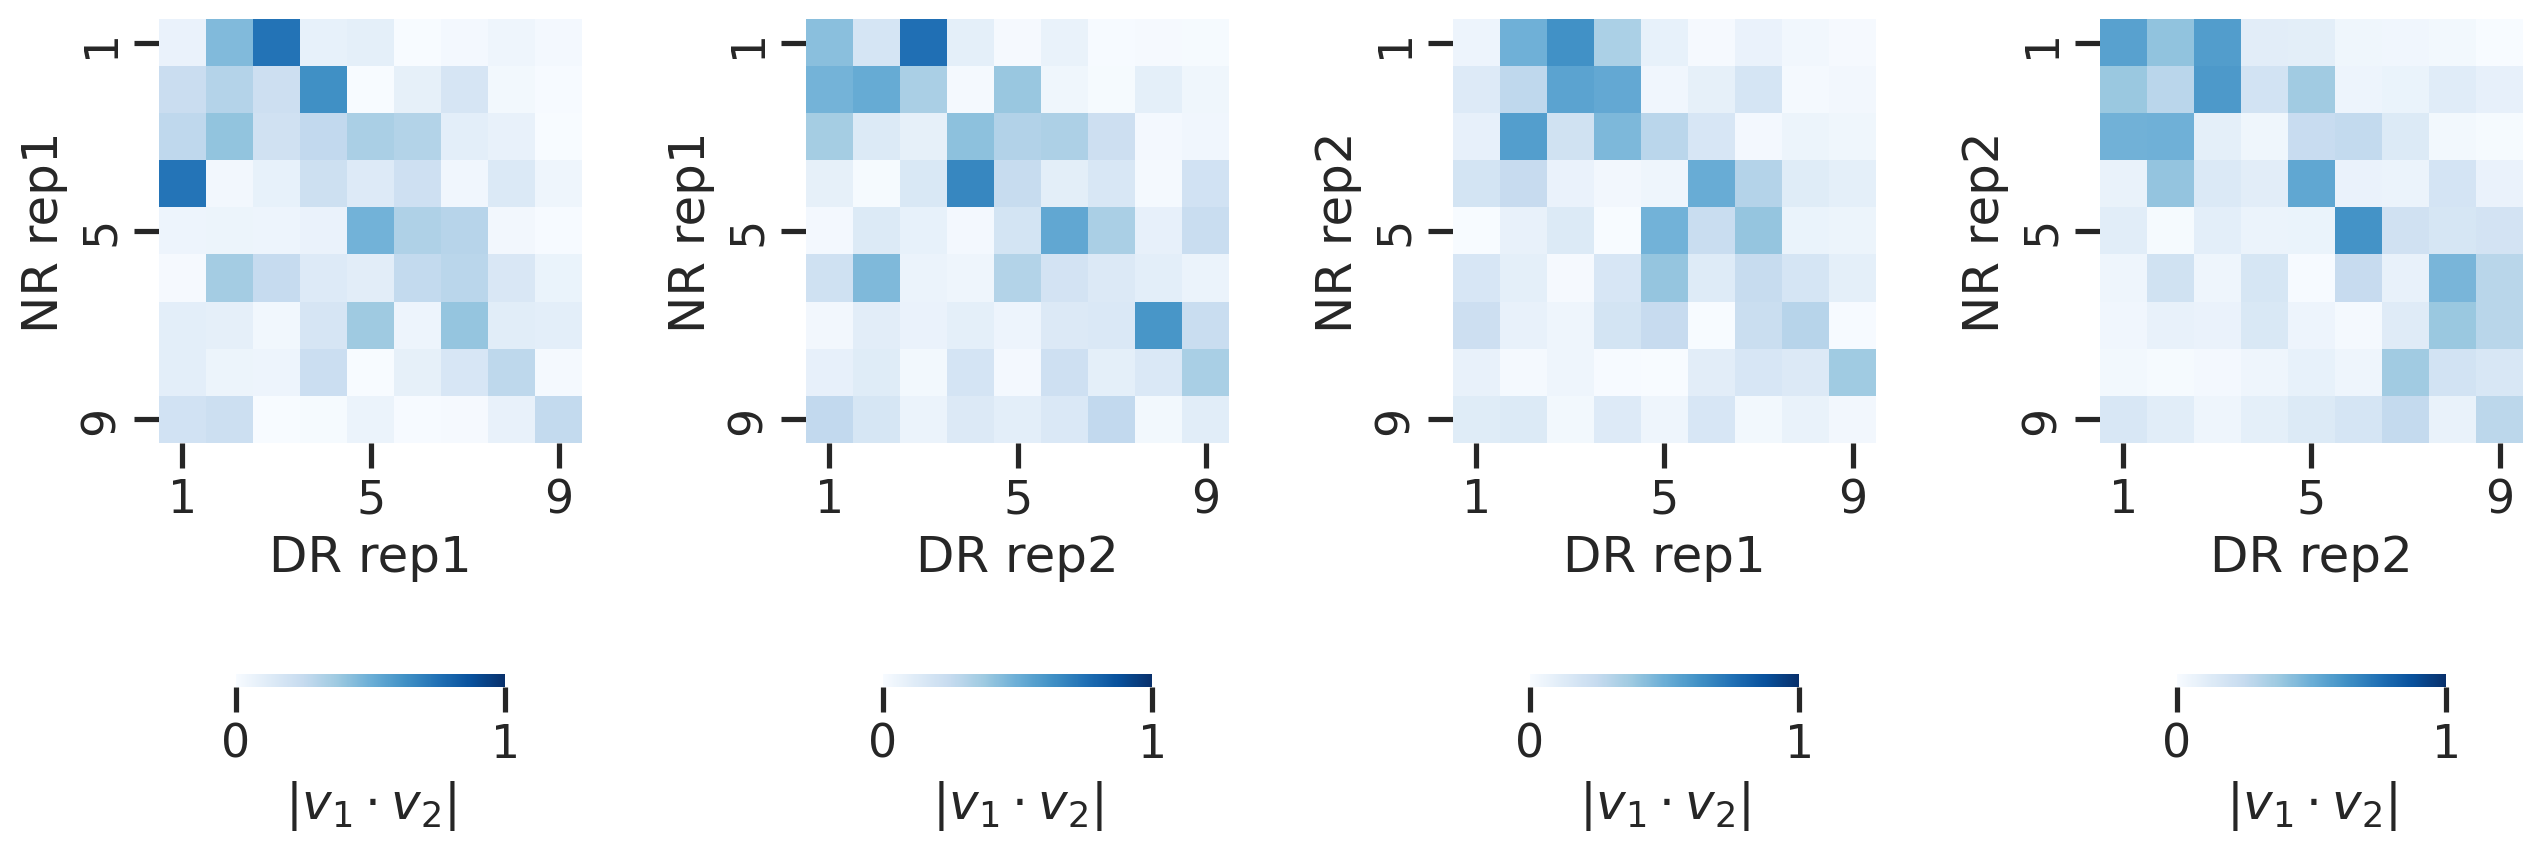

In [26]:
fig, axs = plt.subplots(1,4, figsize=(4*4,1*5))
cases = [
    ["NR rep1", "DR rep1", np.abs(vt_nr1[:9].dot(vt_dr1[:9].T))],
    ["NR rep1", "DR rep2", np.abs(vt_nr1[:9].dot(vt_dr2[:9].T))],
    ["NR rep2", "DR rep1", np.abs(vt_nr2[:9].dot(vt_dr1[:9].T))],
    ["NR rep2", "DR rep2", np.abs(vt_nr2[:9].dot(vt_dr2[:9].T))],
]
for case, ax in zip(cases, axs):
    ylbl, xlbl, mat = case
    sns.heatmap(mat, 
                cmap='Blues', vmin=0, vmax=1,
                xticklabels=4, yticklabels=4, 
                cbar_kws=dict(location='bottom', shrink=0.5, label=r'$|v_1 \cdot v_2|$', pad=0.3),
                ax=ax,
               )
    ax.set_xticklabels([int(i.get_text())+1 for i in ax.get_xticklabels()])
    ax.set_yticklabels([int(i.get_text())+1 for i in ax.get_yticklabels()])
    ax.set_aspect('equal')
    ax.set_ylabel(ylbl)
    ax.set_xlabel(xlbl)
output = os.path.join(outfigdir, 'pcdot_heatmap_s2.pdf')
powerplots.savefig(fig, output)
plt.show()

In [27]:
pca_bt = norm_pca(adata)
pca_nr = norm_pca(adata_nr)
pca_dr = norm_pca(adata_dr)

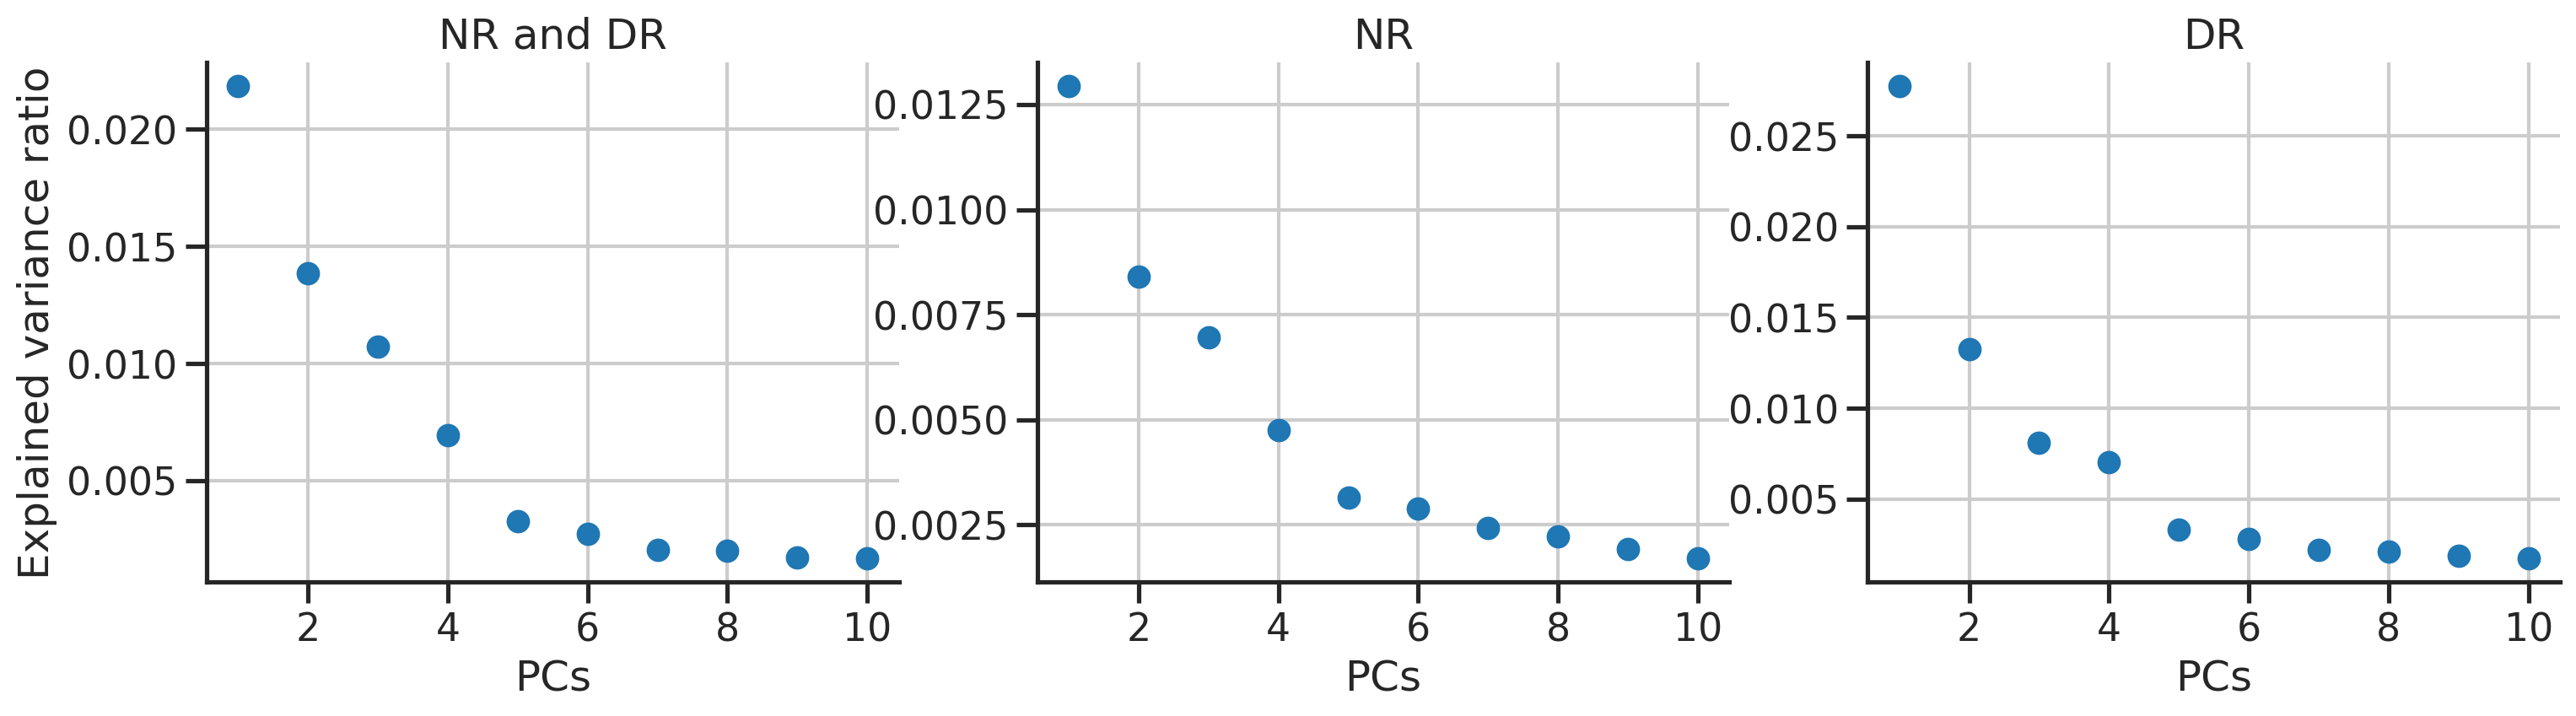

In [28]:

fig, axs = plt.subplots(1,3,figsize=(3*6, 1*4))
ax = axs[0]
ax.plot(1+np.arange(10), pca_bt.explained_variance_ratio_[:10], 'o')
sns.despine(ax=ax)
ax.set_title('NR and DR')
ax.set_ylabel('Explained variance ratio')
ax.set_xlabel('PCs')

ax = axs[1]
ax.plot(1+np.arange(10), pca_nr.explained_variance_ratio_[:10], 'o')
sns.despine(ax=ax)
ax.set_title('NR')
ax.set_xlabel('PCs')

ax = axs[2]
ax.plot(1+np.arange(10), pca_dr.explained_variance_ratio_[:10], 'o')
sns.despine(ax=ax)
ax.set_title('DR')
ax.set_xlabel('PCs')
output = os.path.join(outfigdir, 'pca_varratio.pdf')
powerplots.savefig(fig, output)
plt.show()
